In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Conflict and Agricultural Output

This notebook conducts a diff-in-diff analysis to understand if conflict ahs impacted agricultural activity.

EVI is considered as a proxy for agricultural output. Fixed effects are taken from rainfall. Conflict values are obatined from ACLED. Additionally, we use crop area statistics to see if crop area changed because of conflict. 


In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from acled_conflict_analysis import processing, visuals

In [9]:
from pathlib import Path

PROJECT_ROOT = Path().cwd().parent.parent
DATA_PATH = PROJECT_ROOT / "data"
EVI_PATH = DATA_PATH / "agriculture" / "EVI"
CROPLAND_PATH = DATA_PATH / "agriculture" / "Crop Land"
BOUNDARIES_PATH = DATA_PATH / "boundaries"

In [10]:
conflict = pd.read_csv('../../data/conflict/acled_raw_20250925.csv')
processing.data_type_conversion(conflict)
conflict.drop(columns=['Unnamed: 0'], inplace=True)
#conflict['event_date'].min()

In [11]:
eth_adm0 = gpd.read_file('../../data/boundaries/eth_admbnda_adm0_csa_bofedb_itos_2021.shp')
eth_adm1 = gpd.read_file('../../data/boundaries/Region_14/Regions_14.shp')
eth_adm2 = gpd.read_file('../../data/boundaries/eth_admbnda_adm2_csa_bofedb_2021.shp')
eth_adm3 = gpd.read_file('../../data/boundaries/eth_admbnda_adm3_csa_bofedb_2021.shp')

In [12]:
conflict_adm3 = processing.get_acled_by_admin(eth_adm3, conflict, freq='MS', columns=['ADM3_EN', 'ADM2_EN', 'ADM1_EN'])
conflict_adm2 = processing.get_acled_by_admin(eth_adm2, conflict, freq='MS', columns=['ADM2_EN', 'ADM1_EN'])
conflict_adm1 = processing.get_acled_by_admin(eth_adm1, conflict, freq='MS', columns=['ADM1_EN'])
conflict_adm0 = processing.get_acled_by_admin(eth_adm0, conflict, freq='YS', columns=['ADM0_EN'])
conflict_adm0['year'] = conflict_adm0['event_date'].dt.year


In [13]:
crop_area_adm2 = pd.read_csv('../../data/agriculture/crop_area_adm2.csv')
crop_area_adm3 = pd.read_csv('../../data/agriculture/crop_area_adm3.csv')
crop_area_adm0 = crop_area_adm2.groupby(['year'])['crop_area'].sum().reset_index()

In [14]:
evi_adm0 = pd.read_csv('../../data/agriculture/evi_dw_adm0.csv')
evi_adm1 = pd.read_csv('../../data/agriculture/evi_dw_adm1.csv')
evi_adm2 = pd.read_csv('../../data/agriculture/evi_dw_adm2.csv')
evi_adm3 = pd.read_csv('../../data/agriculture/evi_dw_adm3.csv')

evi_adm0['date'] = pd.to_datetime(evi_adm0['date'])
evi_adm0 = evi_adm0.groupby(pd.Grouper(key='date', freq='YS'))['EVI'].median().reset_index()
evi_adm0['year'] = evi_adm0['date'].dt.year

In [15]:
rainfall_adm1 = pd.concat([pd.read_csv('../../data/rainfall/adm1/ethiopia_chirps_rainfall_2015-01-01_2025-01-01_monthly.csv'), 
                           pd.read_csv('../../data/rainfall/adm1/ethiopia_chirps_rainfall_2025-01-01_2025-10-01_monthly.csv')])
rainfall_adm2 = pd.concat([pd.read_csv('../../data/rainfall/adm2/ethiopia_chirps_rainfall_2015-01-01_2025-01-01_monthly.csv'), 
                           pd.read_csv('../../data/rainfall/adm2/ethiopia_chirps_rainfall_2025-01-01_2025-10-01_monthly.csv')])
rainfall_adm3 = pd.concat([pd.read_csv('../../data/rainfall/adm3/ethiopia_chirps_rainfall_2015-01-01_2025-01-01_monthly.csv'), 
                           pd.read_csv('../../data/rainfall/adm3/ethiopia_chirps_rainfall_2025-01-01_2025-10-01_monthly.csv')])

rainfall_adm1['date'] = pd.to_datetime(rainfall_adm1['date'])
rainfall_adm2['date'] = pd.to_datetime(rainfall_adm2['date'])
rainfall_adm3['date'] = pd.to_datetime(rainfall_adm3['date'])

rainfall_adm0 = rainfall_adm1.groupby(pd.Grouper(key='date', freq='YS'))['rainfall_mm'].sum().reset_index()
rainfall_adm0['year'] = rainfall_adm0['date'].dt.year

In [16]:
from functools import reduce

# Merge all ADM0 dataframes on 'year' column
merged_adm0 = reduce(lambda left, right: pd.merge(left, right, on='year', how='outer'), 
					 [rainfall_adm0, evi_adm0, conflict_adm0, crop_area_adm0])

merged_adm0 = merged_adm0[['year', 'rainfall_mm', 'EVI', 'nrFatalities', 'nrEvents', 'crop_area']]

## National Trends

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


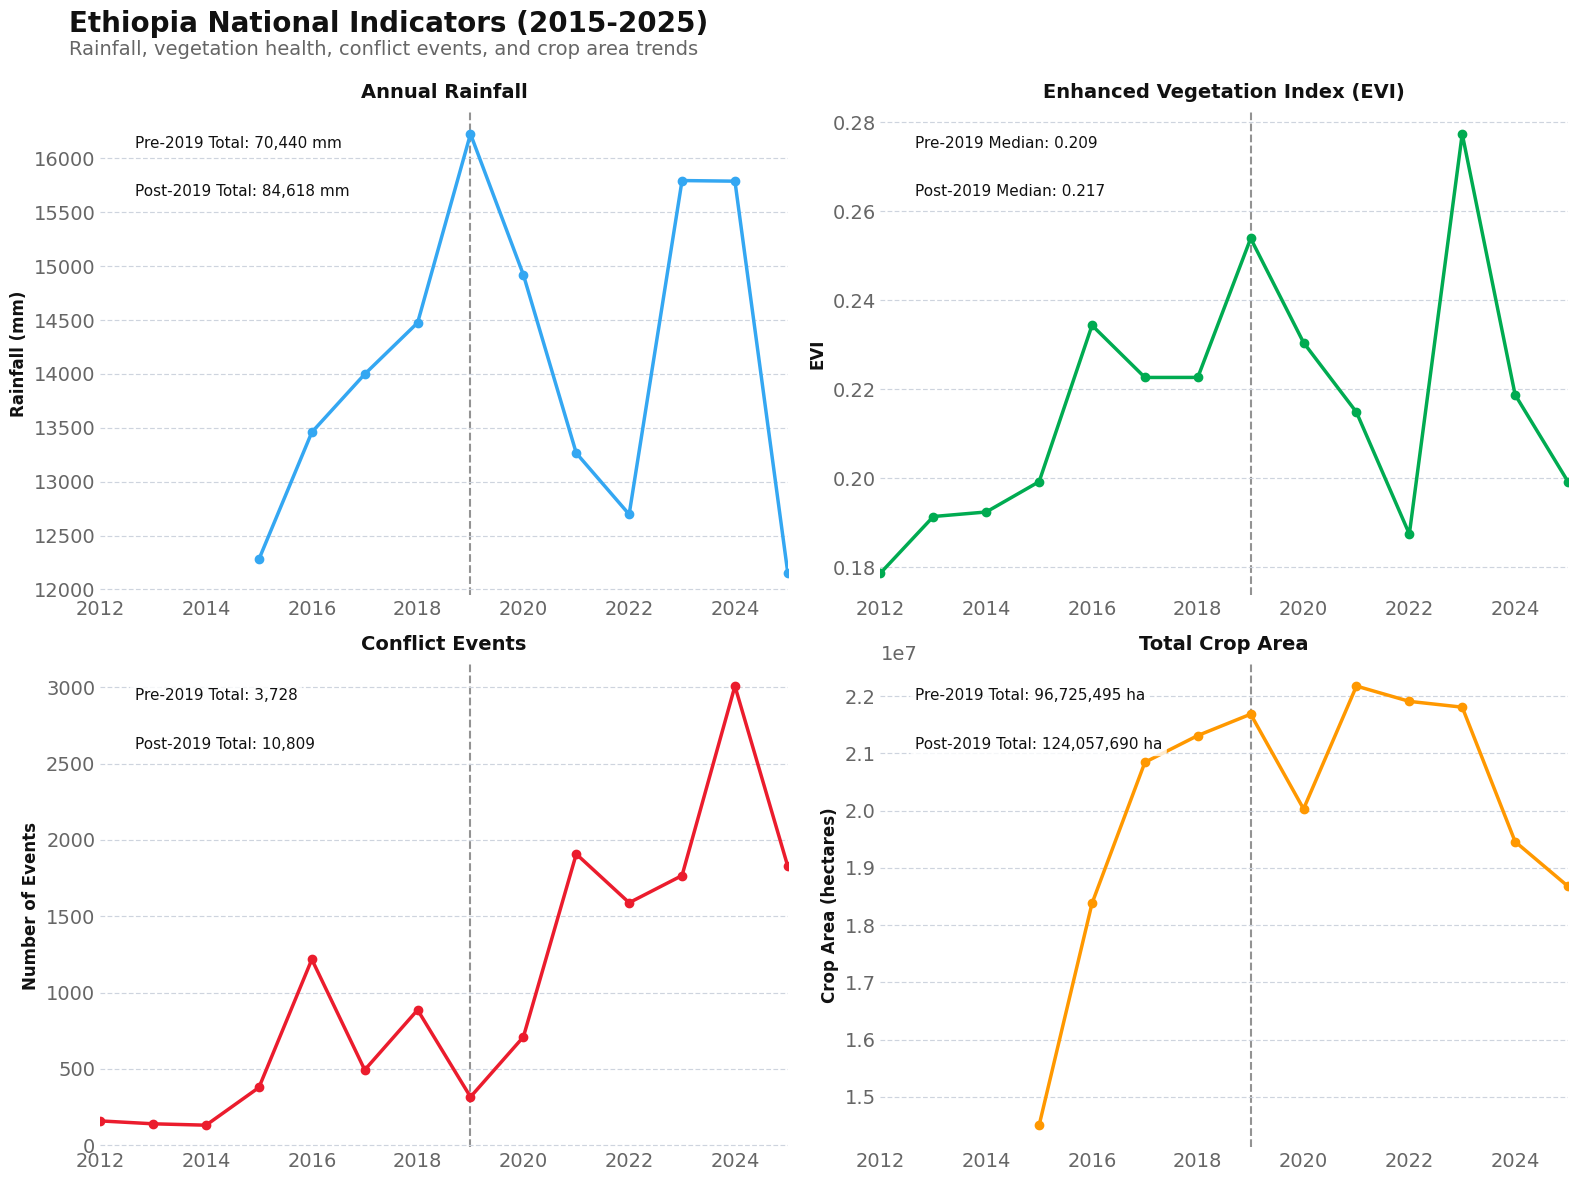

In [17]:
%load_ext autoreload
%autoreload 2
from visuals import plot_national_indicators

fig, axes = plot_national_indicators(merged_adm0)

## Identifying Control and Treatment Groups

This analysis uses a difference-in-differences design to estimate the causal effect of conflict escalation on agricultural vegetation (EVI).

**Step 1: Exclude Low Agricultural Regions**
- Remove the bottom 50% of regions by crop area (median threshold)
- Result: ~541 regions excluded from analysis

**Step 2: Classify Remaining Regions by Conflict Pattern**

Time periods:
- **Pre-conflict period**: 2015-2019 (≤2019)
- **Post-conflict period**: 2020-2025 (>2019)

Classification criteria (using 10 events per period as threshold):

1. **Treatment Group - "New Conflict"**: 
   - Pre-conflict: ≤10 events
   - Post-conflict: >10 events
   - These regions experienced conflict escalation after 2019

2. **Control Group - "No/Low Conflict"**:
   - No conflict: 0 events in ACLED database
   - Low conflict: ≤10 events in both periods
   - These regions remained peaceful or had minimal conflict throughout

3. **Excluded from DiD Analysis**:
   - **Reduced conflict**: pre>10, post≤10 (conflict de-escalation)
   - **Persistent conflict**: >10 events in both periods (always high conflict)

### Identification Strategy

The treatment effect (β₁) is identified by comparing:
- The change in EVI for **new conflict regions** (pre to post 2019)
- vs. the change in EVI for **no/low conflict regions** (pre to post 2019)

**Key Assumption**: Parallel trends - absent conflict escalation, new conflict and no/low conflict regions would have followed similar EVI trajectories.

In [18]:
conflict_adm3['year'] = conflict_adm3['event_date'].dt.year
conflict_adm3['time_category'] = conflict_adm3['year'].apply(
    lambda x: 'Pre-Conflict' if x <= 2019 else 'Post-Conflict'
)

In [19]:
conflict_adm3_cat = conflict_adm3.groupby(['ADM3_EN', 'time_category', 'ADM2_EN'])[['nrEvents', 'nrFatalities']].sum().reset_index()
conflict_adm3_tot = conflict_adm3.groupby(['ADM3_EN', 'ADM2_EN'])[['nrEvents', 'nrFatalities']].sum().reset_index()

In [39]:
crop_area_adm3_tot = crop_area_adm3.groupby(['ADM3_EN'])['crop_area'].mean().reset_index()

# Calculate the 25th percentile (Q1)
q1_threshold = crop_area_adm3_tot['crop_area'].quantile(0.5)

# Get regions in the bottom 25% quartile
bottom_half_regions = crop_area_adm3_tot[crop_area_adm3_tot['crop_area'] <= q1_threshold]

print(f"Total regions with crop area data: {len(crop_area_adm3_tot)}")
print(f"25th percentile threshold: {q1_threshold:.2f}")
print(f"Regions in bottom quartile: {len(bottom_half_regions)}")
print(f"\nMean crop area (overall): {crop_area_adm3_tot['crop_area'].mean():.2f}")
print(f"Mean crop area (bottom quartile): {bottom_half_regions['crop_area'].mean():.2f}")

# Store the list of bottom quartile regions
bottom_half_crop_regions = bottom_half_regions['ADM3_EN'].tolist()
print(f"\nFirst 10 regions in bottom quartile: {bottom_half_crop_regions[:10]}")


Total regions with crop area data: 1082
25th percentile threshold: 10350.45
Regions in bottom quartile: 541

Mean crop area (overall): 18549.13
Mean crop area (bottom quartile): 2920.74

First 10 regions in bottom quartile: ['Aba-Korow', 'Abaala', 'Abaala town', 'Abadir', 'Abela Abaya', 'Abergele (TG)', 'Abi Adi town', 'Abobo', 'Aboker', 'Adagn Ager Chaqo']


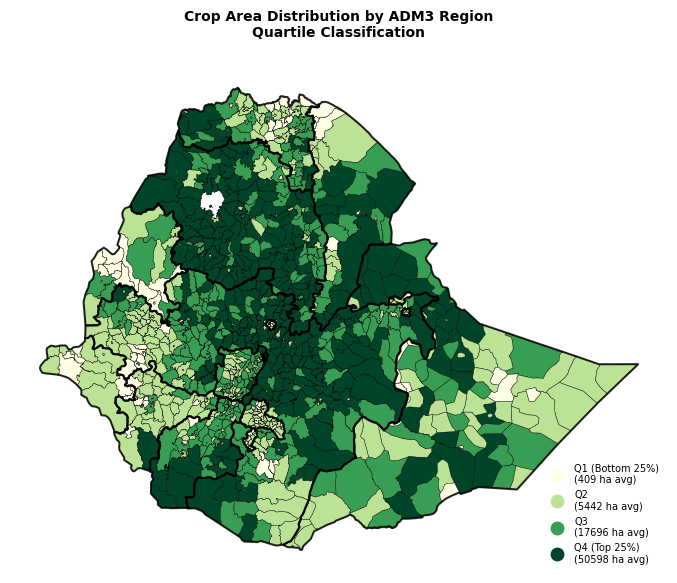

In [21]:
# Assign quartiles to all regions
crop_area_adm3_tot['quartile'] = pd.qcut(crop_area_adm3_tot['crop_area'], 
                                          q=4, 
                                          labels=['Q1 (Bottom 25%)', 'Q2', 'Q3', 'Q4 (Top 25%)'])

# Calculate area for each quartile (approximate in km²)
quartile_stats = []
for quartile in ['Q1 (Bottom 25%)', 'Q2', 'Q3', 'Q4 (Top 25%)']:
    q_data = crop_area_adm3_tot[crop_area_adm3_tot['quartile'] == quartile]
    mean_area = q_data['crop_area'].mean()
    quartile_stats.append(f"{quartile}\n({mean_area:.0f} ha avg)")

# Merge with geometry
crop_area_map = eth_adm3[['ADM3_EN', 'geometry']].merge(crop_area_adm3_tot, on='ADM3_EN', how='left')

# Create custom labels with area info
crop_area_map['quartile_label'] = crop_area_map['quartile'].map({
    'Q1 (Bottom 25%)': quartile_stats[0],
    'Q2': quartile_stats[1],
    'Q3': quartile_stats[2],
    'Q4 (Top 25%)': quartile_stats[3]
})

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Plot the quartiles
crop_area_map.plot(column='quartile_label', 
                    ax=ax,
                    legend=True,
                    categorical=True,
                    cmap='YlGn',
                    edgecolor='black',
                    linewidth=0.3,
                    legend_kwds={'loc': 'lower right', 'fontsize': 7})

# Add ADM1 boundaries for reference
eth_adm1.boundary.plot(ax=ax, color='black', linewidth=1.5, alpha=0.8)

# Styling
ax.set_title('Crop Area Distribution by ADM3 Region\nQuartile Classification', 
             fontsize=10, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.show()


In [40]:
new_conflict = []
persistent_conflict = []
reduced_conflict = []
no_conflict = []
low_conflict_list = []

# Get all ADM3 regions from boundaries, excluding bottom quartile of crop area
all_adm3_full = eth_adm3['ADM3_EN'].unique()
bottom_half_regions_set = set(bottom_half_crop_regions)
all_adm3 = [adm3 for adm3 in all_adm3_full if adm3 not in bottom_half_regions_set]

print(f"Total ADM3 regions (before filtering): {len(all_adm3_full)}")
print(f"Bottom quartile regions (excluded): {len(bottom_half_regions_set)}")
print(f"Regions to categorize: {len(all_adm3)}")
print()

for adm3 in all_adm3:
    # Check if this region has any conflict data
    if adm3 not in conflict_adm3_cat['ADM3_EN'].values:
        # Region has no conflict data at all - add to no_conflict
        no_conflict.append(adm3)
        continue
    
    df = conflict_adm3_cat[conflict_adm3_cat['ADM3_EN']==adm3]
    
    # Get data for both time periods
    post_conflict_data = df[df['time_category']=='Post-Conflict']['nrEvents']
    pre_conflict_data = df[df['time_category']=='Pre-Conflict']['nrEvents']
    
    # Get values (0 if no data for that period - treat as no conflict)
    post_events = post_conflict_data.values[0] if len(post_conflict_data) > 0 else 0
    pre_events = pre_conflict_data.values[0] if len(pre_conflict_data) > 0 else 0
    
    # Categorize based on conflict patterns
    if post_events > 10 and pre_events <= 10:
        # New conflict: low/no conflict before (<=10), high conflict after (>10)
        # This includes regions with conflict only in post period
        new_conflict.append(adm3)
    elif pre_events > 10 and post_events <= 10:
        # Reduced conflict: high conflict before (>10), low/no conflict after (<=10)
        # This includes regions with conflict only in pre period
        reduced_conflict.append(adm3)
    elif post_events > 10 and pre_events > 10:
        # Persistent conflict (>10 events in both periods)
        persistent_conflict.append(adm3)
    else:
        # Low conflict: both periods have <=10 events
        # This catches regions with <=10 in both periods even if total > 10
        low_conflict_list.append(adm3)

print(f"\n=== Conflict Categories (excluding bottom quartile crop area) ===")
print(f"No conflict (not in conflict database): {len(no_conflict)}")
print(f"Low conflict (<=10 events per period): {len(low_conflict_list)}")
print(f"New conflict (pre<=10, post>10): {len(new_conflict)}")
print(f"Reduced conflict (pre>10, post<=10): {len(reduced_conflict)}")
print(f"Persistent conflict (>10 events both periods): {len(persistent_conflict)}")
print(f"\nTotal categorized: {len(no_conflict) + len(low_conflict_list) + len(new_conflict) + len(reduced_conflict) + len(persistent_conflict)}")
print(f"Difference from filtered total: {len(all_adm3) - (len(no_conflict) + len(low_conflict_list) + len(new_conflict) + len(reduced_conflict) + len(persistent_conflict))}")

# Check for overlaps between lists
print("\n=== Checking for overlaps ===")
all_lists = {
    'no_conflict': set(no_conflict),
    'low_conflict': set(low_conflict_list),
    'new_conflict': set(new_conflict),
    'reduced_conflict': set(reduced_conflict),
    'persistent_conflict': set(persistent_conflict)
}

overlaps_found = False
for name1, list1 in all_lists.items():
    for name2, list2 in all_lists.items():
        if name1 < name2:  # Compare each pair only once
            overlap = list1 & list2
            if overlap:
                print(f"OVERLAP between {name1} and {name2}: {len(overlap)} regions")
                print(f"  Regions: {sorted(list(overlap))[:5]}{'...' if len(overlap) > 5 else ''}")
                overlaps_found = True

if not overlaps_found:
    print("No overlaps found - all regions are uniquely categorized!")


Total ADM3 regions (before filtering): 1082
Bottom quartile regions (excluded): 541
Regions to categorize: 541


=== Conflict Categories (excluding bottom quartile crop area) ===
No conflict (not in conflict database): 103
Low conflict (<=10 events per period): 232
New conflict (pre<=10, post>10): 160
Reduced conflict (pre>10, post<=10): 28
Persistent conflict (>10 events both periods): 18

Total categorized: 541
Difference from filtered total: 0

=== Checking for overlaps ===
No overlaps found - all regions are uniquely categorized!


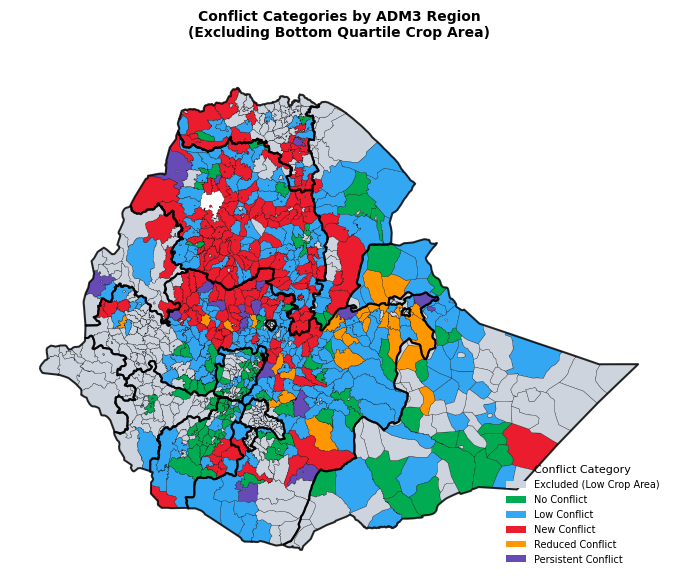

Excluded (Low Crop Area): 541 regions
No Conflict: 103 regions
Low Conflict: 232 regions
New Conflict: 160 regions
Reduced Conflict: 28 regions
Persistent Conflict: 18 regions


In [41]:
# Import WB colors
from visuals import WB_COLORS

# Create a dataframe mapping regions to conflict categories
conflict_categories = []

for adm3 in eth_adm3['ADM3_EN'].unique():
    if adm3 in bottom_half_regions_set:
        category = 'Excluded (Low Crop Area)'
    elif adm3 in no_conflict:
        category = 'No Conflict'
    elif adm3 in low_conflict_list:
        category = 'Low Conflict'
    elif adm3 in new_conflict:
        category = 'New Conflict'
    elif adm3 in reduced_conflict:
        category = 'Reduced Conflict'
    elif adm3 in persistent_conflict:
        category = 'Persistent Conflict'
    else:
        category = 'Uncategorized'
    
    conflict_categories.append({'ADM3_EN': adm3, 'conflict_category': category})

conflict_cat_df = pd.DataFrame(conflict_categories)

# Merge with geometry
conflict_map = eth_adm3[['ADM3_EN', 'geometry']].merge(conflict_cat_df, on='ADM3_EN', how='left')

# Define custom colors using WB palette
category_colors = {
    'Excluded (Low Crop Area)': '#CED4DE',  # WB grid color
    'No Conflict': '#00AB51',  # WB green
    'Low Conflict': '#34A7F2',  # WB cat1 blue
    'New Conflict': '#EB1C2D',  # WB red
    'Reduced Conflict': '#FF9800',  # WB cat2 orange
    'Persistent Conflict': '#664AB6'  # WB cat3 purple
}

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Plot using the column with categorical coloring
from matplotlib.patches import Patch
conflict_map['color'] = conflict_map['conflict_category'].map(category_colors)
conflict_map.plot(ax=ax, color=conflict_map['color'], edgecolor='black', linewidth=0.2)

# Add ADM1 boundaries
eth_adm1.boundary.plot(ax=ax, color='black', linewidth=1.5, alpha=0.8)

# Create legend manually
legend_elements = [Patch(facecolor=color, edgecolor='none', label=category) 
                   for category, color in category_colors.items()]
ax.legend(handles=legend_elements, loc='lower right', fontsize=7, 
          title='Conflict Category', title_fontsize=8, framealpha=0.9)

# Styling
ax.set_title('Conflict Categories by ADM3 Region\n(Excluding Bottom Quartile Crop Area)', 
             fontsize=10, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.show()

# Print summary
#print("\n=== Map Summary ===")
for category in category_colors.keys():
    count = len(conflict_map[conflict_map['conflict_category'] == category])
    print(f"{category}: {count} regions")


## Difference-in-Difference Regression



EVI_it = β₀ + β₁(NewConflict_i × Post_t) + β₂(Rainfall_it) + β₃(CropArea_it)
         + α_i + γ_t + ε_it


- EVI_it = Enhanced Vegetation Index for region i in month t
- NewConflict_i = 1 if region escalated to conflict, 0 if no/low conflict
- Post_t = 1 if month ≥ 2019, 0 otherwise
- Rainfall_it = Rainfall in current month (mm)
- CropArea_it = Crop area in region i in year t (hectares)
- α_i = Admin 3 region fixed effects
- γ_t = Monthly time fixed effects


**Note:** CropSeason variable is omitted as it's perfectly collinear with monthly time fixed effects (TimeEffects).

**Assumptions: The treatment and control groups will grow in the same way, if not for conflict.**

In [24]:
conflict_adm3 = conflict_adm3[['ADM3_EN', 'ADM2_EN',  'event_date', 'nrEvents', 'nrFatalities']]
conflict_adm3.rename(columns={'event_date':'date'}, inplace=True)

In [25]:
rainfall_adm3.rename(columns={'region':'ADM3_EN'}, inplace=True)

In [26]:
evi_adm3 = evi_adm3[['ADM2_EN', 'ADM3_EN', 'date', 'EVI']]
evi_adm3['date'] = pd.to_datetime(evi_adm3['date'])
evi_adm3 = evi_adm3.groupby(['ADM2_EN', 'ADM3_EN', pd.Grouper(key='date', freq='MS')])['EVI'].median().reset_index()

In [27]:
merged = evi_adm3.merge(conflict_adm3, on=['ADM3_EN', 'ADM2_EN', 'date'], how='left').merge(rainfall_adm3, on=['ADM3_EN', 'date'], how='left')
merged = merged[merged['date'].dt.year>=2012]

In [28]:
merged['NewConflict'] = merged['ADM3_EN'].apply(lambda x: 1 if x in new_conflict else 0 if x in no_conflict + low_conflict_list else None)
merged['Post_t'] = merged['date'].dt.year.apply(lambda x: 1 if x >= 2019 else 0)
merged['rainfall_lag1'] = merged.groupby(['ADM2_EN','ADM3_EN'])['rainfall_mm'].shift(1)
merged['rainfall_lag3'] = merged.groupby(['ADM2_EN','ADM3_EN'])['rainfall_mm'].shift(3)
merged['CropSeason'] = merged['date'].dt.month.apply(lambda x: 1 if x in [5,6,7,8,9,10,11,12] else 0)

In [29]:
merged = merged[merged['NewConflict'].notnull()]

In [30]:
merged['treated_post'] = merged['NewConflict'] * merged['Post_t']

In [31]:
merged['admin_category'] = merged['ADM3_EN'].apply(lambda x: 'No/Low Conflict' if x in no_conflict + low_conflict_list else 'New Conflict' if x in new_conflict else 'Unknown')

In [32]:
merged['year'] = merged['date'].dt.year

In [33]:
merged = merged.merge(crop_area_adm3[['ADM3_EN', 'year', 'crop_area']], on=['ADM3_EN', 'year'], how='left')

Total Admin 3 regions: 495
  - Treatment (New Conflict): 160
  - Control (No Conflict): 335
Total observations: 62,854
Time period: 2015 - 2025
Number of crop seasons: 2
T-TEST FOR PRE-2019 EVI DIFFERENCE
t-statistic: 2.341
p-value: 0.019


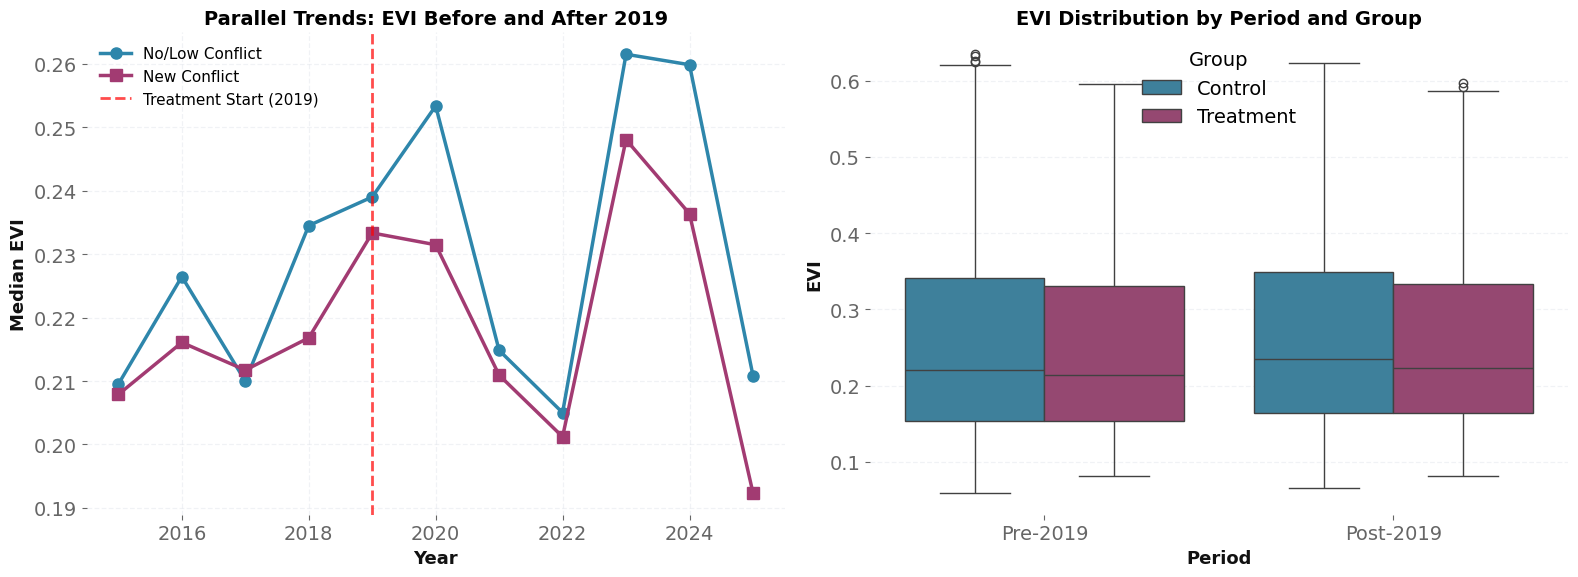

In [34]:
import pandas as pd
import numpy as np
from linearmodels import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

df_simple = merged.dropna(subset=['EVI', 'rainfall_mm', 'rainfall_lag1'])

print(f"Total Admin 3 regions: {df_simple['ADM3_EN'].nunique()}")
print(f"  - Treatment (New Conflict): {df_simple[df_simple['NewConflict']==1]['ADM3_EN'].nunique()}")
print(f"  - Control (No Conflict): {df_simple[df_simple['NewConflict']==0]['ADM3_EN'].nunique()}")
print(f"Total observations: {len(df_simple):,}")
print(f"Time period: {df_simple['year'].min()} - {df_simple['year'].max()}")
print(f"Number of crop seasons: {df_simple['CropSeason'].nunique()}")


# Pre-2019 data
pre_2019 = df_simple[df_simple['Post_t'] == 0]

# balance = pre_2019.groupby('admin_category').agg({
#     'EVI': ['mean', 'std', 'count'],
#     'rainfall_mm': ['mean', 'std'],
#     'nrEvents': ['sum', 'mean'],
#     'ADM3_EN': 'nunique'
# })

# balance.columns = ['_'.join(col).strip() for col in balance.columns.values]
# print(balance.round(4))

# Test for baseline differences in EVI
control_evi = pre_2019[pre_2019['NewConflict']==0]['EVI']
treat_evi = pre_2019[pre_2019['NewConflict']==1]['EVI']

t_stat, p_val = ttest_ind(control_evi, treat_evi)
print("T-TEST FOR PRE-2019 EVI DIFFERENCE")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.3f}")

# if p_val > 0.05:
#     print("✓ No significant baseline difference (good for parallel trends assumption)")
# else:
#     print("⚠ Significant baseline difference - examine parallel trends plot carefully")

# ============================================================
# STEP 3: PARALLEL TRENDS VISUALIZATION
# ============================================================



# Calculate mean EVI by group and year
annual_trends = df_simple.groupby(['admin_category', 'year'])['EVI'].median().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Annual trends
for category, color, marker in [('No/Low Conflict', '#2E86AB', 'o'), 
                                 ('New Conflict', '#A23B72', 's')]:
    data = annual_trends[annual_trends['admin_category'] == category]
    axes[0].plot(data['year'], data['EVI'], 
                 marker=marker, linewidth=2.5, markersize=8, 
                 label=category, color=color)

axes[0].axvline(x=2019, color='red', linestyle='--', linewidth=2, 
                label='Treatment Start (2019)', alpha=0.7)
axes[0].set_xlabel('Year', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Median EVI', fontsize=13, fontweight='bold')
axes[0].set_title('Parallel Trends: EVI Before and After 2019', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11, loc='best', framealpha=0.9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution by period
data_plot = df_simple.copy()
data_plot['Period'] = data_plot['Post_t'].map({0: 'Pre-2019', 1: 'Post-2019'})
data_plot['Group'] = data_plot['NewConflict'].map({0: 'Control', 1: 'Treatment'})

sns.boxplot(data=data_plot, x='Period', y='EVI', hue='Group', ax=axes[1], palette=['#2E86AB', '#A23B72'])
axes[1].set_title('EVI Distribution by Period and Group', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Period', fontsize=13, fontweight='bold')
axes[1].set_ylabel('EVI', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
#plt.savefig('parallel_trends_simple.png', dpi=300, bbox_inches='tight')
plt.show()

#print("✓ Saved: parallel_trends_simple.png")



**Does Conflict Impact EVI?**

In [ ]:

# ============================================================
# STEP 4: RUN DiD WITH CROP SEASON FIXED EFFECTS
# ============================================================

# Set panel structure using ADM3_EN as entity and CropSeason as time
df_panel = df_simple.set_index(['ADM3_EN', 'date'])

# Run two-way fixed effects DiD
model = PanelOLS.from_formula(
    '(EVI) ~ treated_post + rainfall_mm + crop_area + EntityEffects + TimeEffects',
    data=df_panel,
    drop_absorbed=True
)

result = model.fit(cov_type='clustered', cluster_entity=True)

result.summary


/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_19197/2681300166.py:15: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

CropSeason

  result = model.fit(cov_type='clustered', cluster_entity=True)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                    EVI   R-squared:                        0.1618
Estimator:                   PanelOLS   R-squared (Between):              0.2197
No. Observations:               62854   R-squared (Within):               0.2528
Date:                Thu, Oct 30 2025   R-squared (Overall):              0.2234
Time:                        09:37:54   Log-likelihood                 9.237e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4004.7
Entities:                         495   P-value                           0.0000
Avg Obs:                       126.98   Distribution:                 F(3,62230)
Min Obs:                       116.00                                           
Max Obs:                       127.00   F-statistic (robust):             437.85
                                        P-value                           0.0000
Time periods:                     127   Distribution:                 F(3,62230)
Avg Obs:                       494.91                                           
Min Obs:                       494.00                                           
Max Obs:                       495.00                                           
                                                                                
                              Parameter Estimates                               
================================================================================
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
treated_post    -0.0036     0.0012    -3.0986     0.0019     -0.0060     -0.0013
rainfall_mm      0.0004  1.154e-05     35.707     0.0000      0.0004      0.0004
crop_area    -2.179e-07  5.908e-08    -3.6881     0.0002  -3.337e-07  -1.021e-07
================================================================================

F-test for Poolability: 188.39
P-value: 0.0000
Distribution: F(620,62230)

Included effects: Entity, Time
"""

## Propensity Score Matching

Address selection bias by matching treatment and control regions with similar pre-treatment characteristics.

In [703]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# ============================================================
# STEP 1: PREPARE PRE-TREATMENT DATA FOR MATCHING
# ============================================================

# Get pre-treatment period (2015-2018) data for matching
pre_treatment = df_simple[df_simple['Post_t'] == 0].copy()

# Calculate pre-treatment averages by region
pre_means = pre_treatment.groupby('ADM3_EN').agg({
    'EVI': 'mean',
    'rainfall_mm': 'mean',
    'crop_area': 'mean',
    'NewConflict': 'first'
}).reset_index()

print(f"Pre-treatment summary statistics:")
print(f"  Treatment regions: {len(pre_means[pre_means['NewConflict']==1])}")
print(f"  Control regions: {len(pre_means[pre_means['NewConflict']==0])}")
print(f"  Time period for matching: 2015-2018")

# ============================================================
# STEP 2: ESTIMATE PROPENSITY SCORES
# ============================================================

# Prepare features for propensity score model
X = pre_means[['EVI', 'rainfall_mm', 'crop_area']].values
y = pre_means['NewConflict'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Estimate propensity scores using logistic regression
ps_model = LogisticRegression(random_state=42, max_iter=1000)
ps_model.fit(X_scaled, y)

# Get propensity scores (probability of being treated)
pre_means['propensity_score'] = ps_model.predict_proba(X_scaled)[:, 1]

print(f"\nPropensity score distribution:")
print(f"  Treatment group: mean={pre_means[pre_means['NewConflict']==1]['propensity_score'].mean():.3f}, "
      f"std={pre_means[pre_means['NewConflict']==1]['propensity_score'].std():.3f}")
print(f"  Control group: mean={pre_means[pre_means['NewConflict']==0]['propensity_score'].mean():.3f}, "
      f"std={pre_means[pre_means['NewConflict']==0]['propensity_score'].std():.3f}")

# ============================================================
# STEP 3: NEAREST NEIGHBOR MATCHING WITH CALIPER
# ============================================================

# Separate treatment and control
treatment_regions = pre_means[pre_means['NewConflict'] == 1].copy()
control_regions = pre_means[pre_means['NewConflict'] == 0].copy()

# Set caliper (0.1 * standard deviation of propensity score)
caliper = 0.1 * pre_means['propensity_score'].std()
print(f"\nMatching parameters:")
print(f"  Caliper: {caliper:.4f}")
print(f"  Matching method: 1:1 nearest neighbor")

# Perform matching
matched_controls = []
matched_treatment = []

treatment_ps = treatment_regions[['propensity_score']].values
control_ps = control_regions[['propensity_score']].values

# Calculate distances between all treatment and control propensity scores
distances = cdist(treatment_ps, control_ps, metric='euclidean')

for i, treatment_idx in enumerate(treatment_regions.index):
    # Find nearest control within caliper
    control_distances = distances[i]
    valid_matches = control_distances <= caliper
    
    if valid_matches.any():
        # Get nearest control within caliper
        nearest_idx = control_distances[valid_matches].argmin()
        control_idx = control_regions.index[valid_matches][nearest_idx]
        
        matched_treatment.append(treatment_regions.loc[treatment_idx, 'ADM3_EN'])
        matched_controls.append(control_regions.loc[control_idx, 'ADM3_EN'])

print(f"\nMatching results:")
print(f"  Treatment regions: {len(treatment_regions)}")
print(f"  Matched treatment regions: {len(matched_treatment)}")
print(f"  Matched control regions: {len(matched_controls)} (unique)")
print(f"  Unmatched treatment regions: {len(treatment_regions) - len(matched_treatment)}")

# ============================================================
# STEP 4: CHECK BALANCE AFTER MATCHING
# ============================================================

matched_sample = pre_means[
    (pre_means['ADM3_EN'].isin(matched_treatment)) | 
    (pre_means['ADM3_EN'].isin(matched_controls))
].copy()

print(f"\n{'='*60}")
print("BALANCE CHECK: Standardized Mean Differences")
print(f"{'='*60}")
print(f"{'Variable':<20} {'Before Match':<15} {'After Match':<15} {'Improvement'}")
print(f"{'-'*60}")

for var in ['EVI', 'rainfall_mm', 'crop_area']:
    # Before matching
    treat_mean = pre_means[pre_means['NewConflict']==1][var].mean()
    control_mean = pre_means[pre_means['NewConflict']==0][var].mean()
    pooled_std = np.sqrt(
        (pre_means[pre_means['NewConflict']==1][var].var() + 
         pre_means[pre_means['NewConflict']==0][var].var()) / 2
    )
    std_diff_before = abs(treat_mean - control_mean) / pooled_std
    
    # After matching
    treat_mean_matched = matched_sample[matched_sample['NewConflict']==1][var].mean()
    control_mean_matched = matched_sample[matched_sample['NewConflict']==0][var].mean()
    pooled_std_matched = np.sqrt(
        (matched_sample[matched_sample['NewConflict']==1][var].var() + 
         matched_sample[matched_sample['NewConflict']==0][var].var()) / 2
    )
    std_diff_after = abs(treat_mean_matched - control_mean_matched) / pooled_std_matched
    
    improvement = ((std_diff_before - std_diff_after) / std_diff_before) * 100
    
    print(f"{var:<20} {std_diff_before:>14.4f} {std_diff_after:>14.4f} {improvement:>13.1f}%")

print(f"{'-'*60}")
print("Note: Standardized differences < 0.1 indicate good balance")
print(f"{'='*60}\n")

Pre-treatment summary statistics:
  Treatment regions: 160
  Control regions: 335
  Time period for matching: 2015-2018

Propensity score distribution:
  Treatment group: mean=0.363, std=0.112
  Control group: mean=0.304, std=0.107

Matching parameters:
  Caliper: 0.0112
  Matching method: 1:1 nearest neighbor

Matching results:
  Treatment regions: 160
  Matched treatment regions: 157
  Matched control regions: 157 (unique)
  Unmatched treatment regions: 3

BALANCE CHECK: Standardized Mean Differences
Variable             Before Match    After Match     Improvement
------------------------------------------------------------
EVI                          0.0603         0.1786        -196.1%
rainfall_mm                  0.2244         0.1447          35.5%
crop_area                    0.3181         0.2247          29.4%
------------------------------------------------------------
Note: Standardized differences < 0.1 indicate good balance



### Visualize Matched Sample

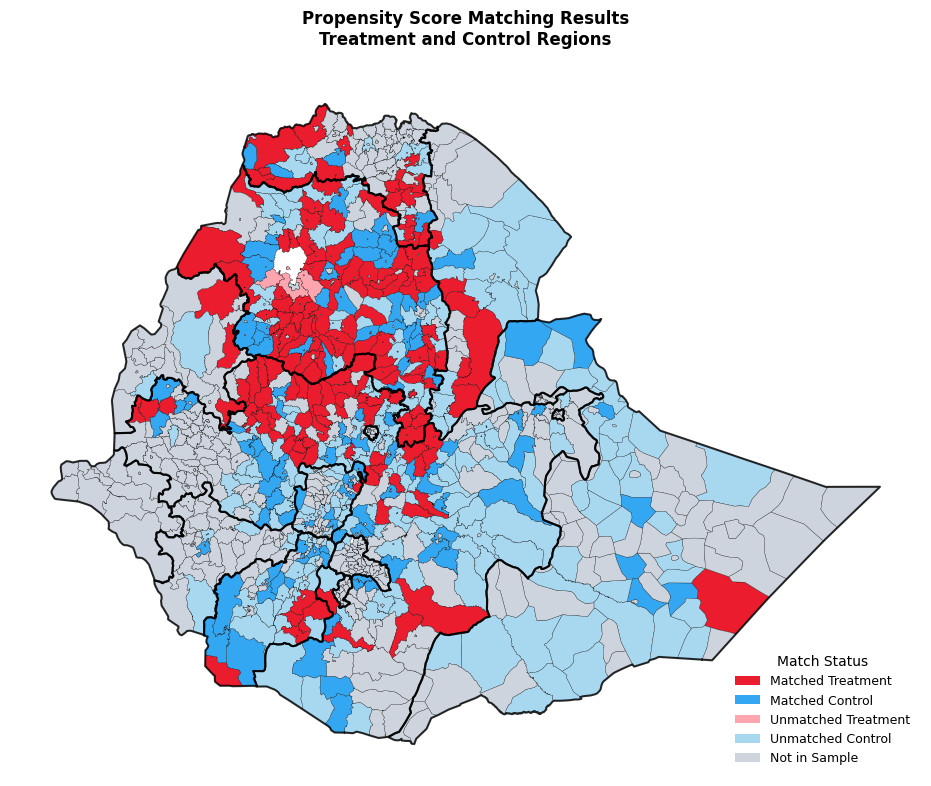


=== Match Status Summary ===
Matched Treatment: 157 regions
Matched Control: 110 regions
Unmatched Treatment: 3 regions
Unmatched Control: 225 regions
Not in Sample: 587 regions


In [704]:
# Create map showing matched vs unmatched regions
matched_map_data = []

for adm3 in eth_adm3['ADM3_EN'].unique():
    if adm3 in matched_treatment:
        status = 'Matched Treatment'
    elif adm3 in matched_controls:
        status = 'Matched Control'
    elif adm3 in new_conflict:
        status = 'Unmatched Treatment'
    elif adm3 in no_conflict + low_conflict_list:
        status = 'Unmatched Control'
    else:
        status = 'Not in Sample'
    
    matched_map_data.append({'ADM3_EN': adm3, 'match_status': status})

matched_status_df = pd.DataFrame(matched_map_data)
matched_map = eth_adm3[['ADM3_EN', 'geometry']].merge(matched_status_df, on='ADM3_EN', how='left')

# Define colors
match_colors = {
    'Matched Treatment': '#EB1C2D',      # Dark red (WB red)
    'Matched Control': '#34A7F2',        # Dark blue (WB blue)
    'Unmatched Treatment': '#FFA5B0',    # Light red
    'Unmatched Control': '#A8D8F0',      # Light blue
    'Not in Sample': '#CED4DE'           # Gray
}

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

matched_map['color'] = matched_map['match_status'].map(match_colors)
matched_map.plot(ax=ax, color=matched_map['color'], edgecolor='black', linewidth=0.2)

# Add ADM1 boundaries
eth_adm1.boundary.plot(ax=ax, color='black', linewidth=1.5, alpha=0.8)

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='none', label=f"{status}") 
                   for status, color in match_colors.items()]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9, 
          title='Match Status', title_fontsize=10, framealpha=0.95)

ax.set_title('Propensity Score Matching Results\nTreatment and Control Regions', 
             fontsize=12, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.show()

# Print summary
print("\n=== Match Status Summary ===")
for status in match_colors.keys():
    count = len(matched_map[matched_map['match_status'] == status])
    print(f"{status}: {count} regions")

### Run DiD on Matched Sample

In [ ]:
# Filter to matched sample only
matched_sample = df_simple[
    df_simple['ADM3_EN'].isin(matched_treatment + matched_controls)
].copy()

print(f"Matched sample statistics:")
print(f"  Total regions: {matched_sample['ADM3_EN'].nunique()}")
print(f"    - Treatment: {matched_sample[matched_sample['NewConflict']==1]['ADM3_EN'].nunique()}")
print(f"    - Control: {matched_sample[matched_sample['NewConflict']==0]['ADM3_EN'].nunique()}")
print(f"  Total observations: {len(matched_sample):,}")
print(f"  Time period: {matched_sample['year'].min()} - {matched_sample['year'].max()}")

# Set panel structure
df_panel_matched = matched_sample.set_index(['ADM3_EN', 'date'])

# Run DiD on matched sample
model_matched = PanelOLS.from_formula(
    '(EVI) ~ treated_post + rainfall_mm + crop_area + EntityEffects + TimeEffects',
    data=df_panel_matched,
    drop_absorbed=True
)

results_matched = model_matched.fit(cov_type='clustered', cluster_entity=True)

print("\n" + "="*70)
print("MATCHED DIFFERENCE-IN-DIFFERENCES RESULTS")
print("="*70)
results_matched.summary

Matched sample statistics:
  Total regions: 267
    - Treatment: 157
    - Control: 110
  Total observations: 33,898
  Time period: 2015 - 2025

MATCHED DIFFERENCE-IN-DIFFERENCES RESULTS


/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_19951/3660358278.py:23: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

CropSeason

  results_matched = model_matched.fit(cov_type='clustered', cluster_entity=True)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                    EVI   R-squared:                        0.1435
Estimator:                   PanelOLS   R-squared (Between):              0.2099
No. Observations:               33898   R-squared (Within):               0.2540
Date:                Wed, Oct 29 2025   R-squared (Overall):              0.2151
Time:                        00:59:15   Log-likelihood                 5.214e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1871.5
Entities:                         267   P-value                           0.0000
Avg Obs:                       126.96   Distribution:                 F(3,33502)
Min Obs:                       116.00                                           
Max Obs:                       127.00   F-statistic (robust):             158.43
                                        P-value                           0.0000
Time periods:                     127   Distribution:                 F(3,33502)
Avg Obs:                       266.91                                           
Min Obs:                       266.00                                           
Max Obs:                       267.00                                           
                                                                                
                              Parameter Estimates                               
================================================================================
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
treated_post    -0.0033     0.0016    -2.0798     0.0376     -0.0064     -0.0002
rainfall_mm      0.0004  1.735e-05     21.590     0.0000      0.0003      0.0004
crop_area    -1.827e-07  7.634e-08    -2.3933     0.0167  -3.323e-07  -3.307e-08
================================================================================

F-test for Poolability: 197.94
P-value: 0.0000
Distribution: F(392,33502)

Included effects: Entity, Time
"""